

---

# Intro - Autoencoder

**Plan** - Produce proof of concept autoencoder architecture.

**Purpose**: Produce a robust, flexible and stable autoencoder architecture that can be used for dimensionality reduction on input data at work. The overall purpose is to be able to use this to encode data that has thousands of features into a latent space representation with fewer (to reduce time complexity of modelling) whilst preserving predictive performance.

**Hypothesis**: with automatic HP tuning an autoencoder can be used to reduce dimensionality of input data, whilst retaining adequate information to accurately reproduce input data.

**Methodology**: Test on multiple datasets - first the Iris dataset, then Pima Indians, then finally credit card fraud dataset. Evaluate and assess model architecture and visualize latent space using PCA/UMAP etc. See below for details on evaluation methods.


# First dataset - iris dataset
---
## Data sourcing and processing


In [30]:

#import packages :

import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'

from google.colab import drive

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
  # Check if drive is mounted by looking for the mount point in the file system.
  # This is a more robust approach than relying on potentially internal variables.
  import os
  if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

#basics
import os
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
!pip install umap-learn
!pip install optuna
from umap import UMAP
import optuna


#table one
!pip install tableone
from tableone import TableOne

#torch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim  # Add this import


#sklearn
!pip install scikit-optimize
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical

from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, random_split, Dataset
!pip install skopt
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical
from skopt.utils import use_named_args
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_iris  # Import the Iris dataset
from sklearn.model_selection import KFold





from imblearn.over_sampling import RandomOverSampler

ERROR: Could not find a version that satisfies the requirement skopt (from versions: none)
ERROR: No matching distribution found for skopt




---

# Autoencoder (Iris dataset)


1.   First we import our data and perform a dimensionality reduction (using UMAP) to see how separable the classes are. We will do the same afterwards on our latent space to check it.

2.   We will then get a Table One of the input data, and later of the reconstructed output data, to compare.

3. We will check the distribution/separation of our latent space by plotting it in 2 dimensions - therefore we will fix our latent space dimensionality HP at 2.

4. Finally as a final evaluation method we will do some basic predictive modelling on the input space vs the reconstructed data, and finally on the latent space representation.



Cuda setup successful
The dataset length is 150
The number of columns is 5
The column names are ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'target'] 

Table one of input data: 
                              Grouped by target                                                    
                                        Missing    Overall          0          1          2 P-Value
n                                                      150         50         50         50        
sepal length (cm), mean (SD)                  0  5.8 (0.8)  5.0 (0.4)  5.9 (0.5)  6.6 (0.6)  <0.001
sepal width (cm), mean (SD)                   0  3.1 (0.4)  3.4 (0.4)  2.8 (0.3)  3.0 (0.3)  <0.001
petal length (cm), mean (SD)                  0  3.8 (1.8)  1.5 (0.2)  4.3 (0.5)  5.6 (0.6)  <0.001
petal width (cm), mean (SD)                   0  1.2 (0.8)  0.2 (0.1)  1.3 (0.2)  2.0 (0.3)  <0.001



/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


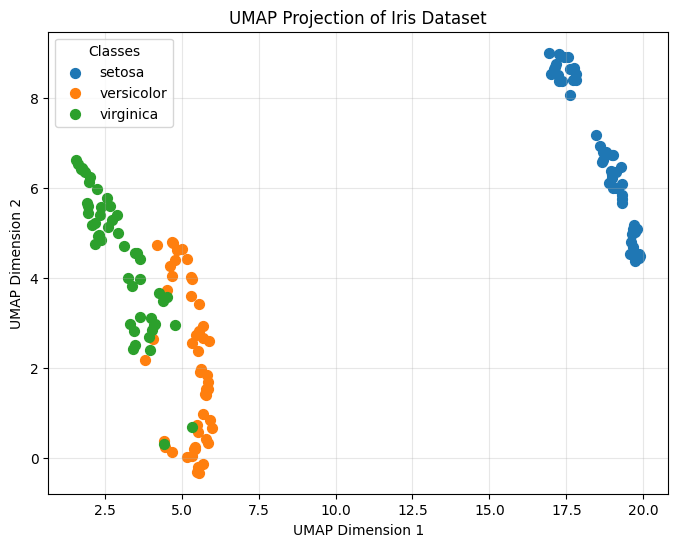

In [5]:
# **Set device for GPU acceleration**
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type != 'cuda':
    print("WARNING: GPU is not available. The model will run on the CPU, which might be slower.")
else:
    print("Cuda setup successful")


#---------------- Dimensionality reduction ----------------#


# Load the Iris dataset
iris = load_iris()
data = iris.data
target = iris.target
target_names = iris.target_names

# Create a Pandas DataFrame for TableOne
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['target'] = iris.target  # Add the target column
iris_columns = iris_df.columns.tolist()

# Print dataset information and TableOne
print(f"The dataset length is {str(len(iris_df))}")
print(f"The number of columns is {str(len(iris_columns))}")
print(f"The column names are {str(iris_columns)} \n")
print("Table one of input data: ")
table1 = TableOne(iris_df, columns=iris_columns, groupby='target', pval=True)
print(table1)

# Scale the data for UMAP
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Apply UMAP
reducer = UMAP(n_components=2, random_state=42)
data_umap = reducer.fit_transform(data_scaled)

# Plot UMAP projection
plt.figure(figsize=(8, 6))
for class_idx, class_name in enumerate(target_names):
    plt.scatter(
        data_umap[target == class_idx, 0],
        data_umap[target == class_idx, 1],
        label=class_name,
        s=50,
    )

plt.title("UMAP Projection of Iris Dataset")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title="Classes")
plt.grid(True, alpha=0.3)
plt.show()


In this trial of the autoencoder, in order to get a meaningful latent space representation we are going to fix latent space dimensionality at 2, so we can compare it to our UMAP.

Now let's visualize our latent space representation to compare it to our UMAP - this will allow us to see how well the data is clustered.

In [28]:
# **Set device for GPU acceleration**
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type != 'cuda':
    print("WARNING: GPU is not available. The model will run on the CPU, which might be slower.")
else:
    print("Cuda setup successful")

# Load and preprocess the iris dataset
iris = load_iris()
data = iris.data

# Scale data to the range [0, 1] for better convergence
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# Convert to PyTorch Dataset
class IrisDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

dataset = IrisDataset(data)

#----------------- Split into training, validation, and test sets -----------------#
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

# **Flexible Autoencoder architecture**
class FlexibleAutoencoder(nn.Module):
    def __init__(self, input_dim, num_encoder_layers, encoder_neurons, num_decoder_layers, decoder_neurons, activations, dropout_prob, use_batchnorm):
        super(FlexibleAutoencoder, self).__init__()

        # Build the encoder
        encoder = []
        in_dim = input_dim
        for i in range(num_encoder_layers):
            out_dim = encoder_neurons if i < num_encoder_layers - 1 else 2  # Fixed latent space dimensionality
            encoder.append(nn.Linear(in_dim, out_dim))
            if use_batchnorm and i < num_encoder_layers - 1:
                encoder.append(nn.BatchNorm1d(out_dim))
            encoder.append(getattr(nn, activations[i])())
            if dropout_prob > 0:
                encoder.append(nn.Dropout(dropout_prob))
            in_dim = out_dim
        self.encoder = nn.Sequential(*encoder)

        # Build the decoder
        decoder = []
        in_dim = 2  # Latent space dimensionality
        for i in range(num_decoder_layers):
            out_dim = decoder_neurons if i < num_decoder_layers - 1 else input_dim
            decoder.append(nn.Linear(in_dim, out_dim))
            if use_batchnorm and i < num_decoder_layers - 1:
                decoder.append(nn.BatchNorm1d(out_dim))
            if i < num_decoder_layers - 1:
                decoder.append(getattr(nn, activations[num_encoder_layers + i])())
            if dropout_prob > 0 and i < num_decoder_layers - 1:
                decoder.append(nn.Dropout(dropout_prob))
            in_dim = out_dim
        self.decoder = nn.Sequential(*decoder)

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return latent, reconstructed

# **Custom loss function: MSE**
def custom_loss_function(reconstructed, original):
    return nn.MSELoss()(reconstructed, original)

# **Training function**
def train_model(model, optimizer, train_loader, val_loader, epochs=50):
    model.to(device)
    train_loss, val_loss = [], []
    criterion = custom_loss_function

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0.0
        for batch in train_loader:
            batch = batch.to(device)
            latent, reconstructed = model(batch)
            loss = criterion(reconstructed, batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        train_loss.append(epoch_train_loss / len(train_loader))

        # Validation
        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                latent, reconstructed = model(batch)
                loss = criterion(reconstructed, batch)
                epoch_val_loss += loss.item()
        val_loss.append(epoch_val_loss / len(val_loader))

    return train_loss, val_loss

# **Testing function**
def test_model(model, test_loader, batch_size, use_batchnorm=False):
    model.eval()
    criterion = custom_loss_function

    # Get the size of the test set
    test_set_size = len(test_loader.dataset)

    # If batch size exceeds the test set size, this will cause an error
    if batch_size > test_set_size:
        #if using batchnorm we cannot just have one batch we are passing in, as it needs to do some statistics based on batches
        if use_batchnorm:
            test_batch_size = max(1, test_set_size // 2)  # Half of test set size if batchnorm is used
        else:
            test_batch_size = test_set_size  # Use full test set size if no batchnorm to get as close as possible to optimum batch size suggested by optimizer
    else:
        test_batch_size = batch_size  # Use the more optimal batch size if it's less than or equal to the test set size

    # Create a new DataLoader with the adjusted batch size
    test_loader = DataLoader(test_loader.dataset, batch_size=test_batch_size, shuffle=False)

    test_loss = 0.0
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            latent, reconstructed = model(batch)
            loss = criterion(reconstructed, batch)
            test_loss += loss.item()

    return test_loss / len(test_loader)  # Return average loss

# Define the Optuna objective function
def objective(trial):
    # Hyperparameter suggestions
    num_encoder_layers = trial.suggest_int("num_encoder_layers", 2, 4)
    num_decoder_layers = trial.suggest_int("num_decoder_layers", 2, 4)  # Decoder layers can be different
    encoder_neurons = trial.suggest_int("encoder_neurons", 8, 128, step=8)
    dropout_prob = trial.suggest_float("dropout_prob", 0.0, 0.5, step=0.05)
    use_batchnorm = trial.suggest_categorical("use_batchnorm", [True, False])
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_int("batch_size", 16, 128, step=16)

    # Select separate activation functions for encoder and decoder layers
    activation_choices = ["ReLU", "LeakyReLU", "Sigmoid", "Tanh"]
    encoder_activation = trial.suggest_categorical("encoder_activation", activation_choices)
    decoder_activation = trial.suggest_categorical("decoder_activation", activation_choices)

    # Create dataloaders
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    # Define the model
    model = FlexibleAutoencoder(
        input_dim=data.shape[1],
        num_encoder_layers=num_encoder_layers,
        encoder_neurons=encoder_neurons,
        num_decoder_layers=num_decoder_layers,  # Decoder can have a different number of layers
        decoder_neurons=encoder_neurons,  # You can experiment with this if you want different neurons for decoder
        activations=[encoder_activation] * num_encoder_layers + [decoder_activation] * num_decoder_layers,  # Separate activations
        dropout_prob=dropout_prob,
        use_batchnorm=use_batchnorm
    )

    # Define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Train the model
    train_loss, val_loss = train_model(model, optimizer, train_loader, val_loader, epochs=100)

    # Return validation loss for hyperparameter tuning
    return val_loss[-1]


# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

# Output the best parameters
print("Best hyperparameters:", study.best_params)

# **Final testing of the optimal model**

# Define the model using the best hyperparameters
best_params = study.best_params
final_model = FlexibleAutoencoder(
    input_dim=data.shape[1],
    num_encoder_layers=best_params["num_encoder_layers"],
    num_decoder_layers=best_params["num_decoder_layers"],  # Different number of decoder layers
    encoder_neurons=best_params["encoder_neurons"],
    decoder_neurons=best_params["encoder_neurons"],  # Optionally adjust decoder neurons
    activations=[best_params["encoder_activation"]] * best_params["num_encoder_layers"] + [best_params["decoder_activation"]] * best_params["num_decoder_layers"],
    dropout_prob=best_params["dropout_prob"],
    use_batchnorm=best_params["use_batchnorm"]
)

# Define optimizer with the best learning rate
final_optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params["lr"])

# Create test loader
test_loader = DataLoader(test_set, batch_size=best_params["batch_size"], shuffle=False)

# Train the final model on the entire training set
train_loss, val_loss = train_model(final_model, final_optimizer, train_loader, val_loader, epochs=100)

# Get the best batch size from the Optuna study
best_batch_size = study.best_params['batch_size']
use_batchnorm = study.best_params['use_batchnorm']

# Run the test model with the selected batch size and batchnorm flag
test_loss = test_model(final_model, test_loader, best_batch_size, use_batchnorm=use_batchnorm)

print("Test loss:", test_loss)


[I 2024-12-11 20:11:21,411] A new study created in memory with name: no-name-a4cac086-6fa7-4833-ac8c-5e01ad81a84a


Cuda setup successful


[I 2024-12-11 20:11:21,734] Trial 0 finished with value: 0.06973154842853546 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'encoder_neurons': 32, 'dropout_prob': 0.15000000000000002, 'use_batchnorm': False, 'lr': 0.0004776140589382631, 'batch_size': 96, 'encoder_activation': 'LeakyReLU', 'decoder_activation': 'LeakyReLU'}. Best is trial 0 with value: 0.06973154842853546.
[I 2024-12-11 20:11:22,712] Trial 1 finished with value: 0.014667664654552937 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 2, 'encoder_neurons': 104, 'dropout_prob': 0.15000000000000002, 'use_batchnorm': True, 'lr': 0.0007043975210042384, 'batch_size': 32, 'encoder_activation': 'Tanh', 'decoder_activation': 'Tanh'}. Best is trial 1 with value: 0.014667664654552937.
[I 2024-12-11 20:11:23,295] Trial 2 finished with value: 0.02292274869978428 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'encoder_neurons': 112, 'dropout_prob': 0.1, 'use_batchnorm': False, 'lr':

Best hyperparameters: {'num_encoder_layers': 3, 'num_decoder_layers': 4, 'encoder_neurons': 104, 'dropout_prob': 0.0, 'use_batchnorm': False, 'lr': 0.0009415708879792061, 'batch_size': 32, 'encoder_activation': 'Tanh', 'decoder_activation': 'LeakyReLU'}
Test loss: 0.0020536405500024557




---

# Auto push to github




In [29]:
import datetime
import os

def commit_to_github(commit_msg):
  """
  Funct to autopush to github
  """

  # Navigate to the repository directory
  %cd /content/drive/MyDrive/Colab_Notebooks/Deep_Learning_Practice

  !git add .

  with open('/content/drive/MyDrive/IAM/PAT.txt', 'r') as file:
        github_pat = file.read().strip()
  os.environ['GITHUB_PAT'] = github_pat

  !git remote add origin "https://github.com/archiegoodman2/machine_learning_practice"

  # Replace with your actual username and email
  USERNAME="archiegoodman2"
  EMAIL="archiegoodman2011@gmail.com"

  # Set global username and email configuration
  !git config --global user.name "$USERNAME"
  !git config --global user.email "$EMAIL"

  now = datetime.datetime.now()
  current_datetime = now.strftime("%Y-%m-%d %H:%M")

  # Set remote URL using the PAT from environment variable
  !git remote set-url origin https://{os.environ['GITHUB_PAT']}@github.com/archiegoodman2/machine_learning_practice.git

  # Replace with your desired commit message
  COMMIT_MESSAGE = str(current_datetime) + " " + str(commit_msg)

  # Commit the changes
  !git commit -m "$COMMIT_MESSAGE"

  # Push to origin (force push if necessary)
  !git push origin master

  return 1

commit_to_github("solved issue with small datasizes causing empty batches when testing on test set")


/content/drive/MyDrive/Colab_Notebooks/Deep_Learning_Practice
error: remote origin already exists.
[master 5717bc5] 2024-12-11 20:17 solved issue with small datasizes causing empty batches when testing on test set
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite nn_autoencoder_iris.ipynb (92%)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 8 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 52.53 KiB | 5.25 MiB/s, done.
Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/archiegoodman2/machine_learning_practice.git
   4e26216..5717bc5  master -> master


1